# Libraries

In [1]:
import pandas as pd
import numpy as np
import pvlib

In [2]:
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain

# Setup

In [3]:
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

In [4]:
spr_315 = sandia_modules['SunPower_SPR_315E_WHT__2007__E__']
sma_3000 = cec_inverters['SMA_America__SB3000TL_US_22__240V__240V__CEC_2018_']

In [5]:
#TODO: Add parameters
stuttgart = Location(latitude=48.77, longitude=9.18)

In [6]:
system = PVSystem(surface_tilt=30,
                  surface_azimuth=180,
                  module_parameters=spr_315,
                  inverter_parameters=sma_3000,
                  modules_per_string=10,
                  strings_per_inverter=1
                 )

# Simulation

In [7]:
mc = ModelChain(system, stuttgart)

In [8]:
one_year = pd.DatetimeIndex(start='2018', periods=8760, freq='1h')
localized_one_year = one_year.tz_localize('Etc/GMT-1')

## Clear sky

In [9]:
np.seterr(invalid='ignore')
mc.run_model(localized_one_year)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temp_model: sapm_temp
  losses_model: no_extra_losses

In [10]:
'Total Yield : %.0f kWh/a' % (mc.ac.sum() / 1000) #WTF!!! No weather so clear sky all the time o_O

'Total Yield : 5768 kWh/a'

In [11]:
'Specific yield : %.0f kWh/kWp.a' % (mc.ac.sum() / (315 * 10) )  #WTF!!! No weather so clear sky all the time o_O

'Specific yield : 1831 kWh/kWp.a'

## With cloud cover

In [12]:
import insel

In [13]:
stuttgart_weather = pd.DataFrame(insel.template('pvlib_weather_generation'), index=localized_one_year, columns=['wind_speed', 'temp_air', 'dni', 'ghi', 'dhi'])

In [14]:
stuttgart_weather.ghi.sum() / 1000

1138.325969685502

In [15]:
mc.run_model(localized_one_year, stuttgart_weather)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temp_model: sapm_temp
  losses_model: no_extra_losses

In [16]:
'Specific yield : %.0f kWh/kWp.a' % (mc.ac.sum() / (315 * 10) )

'Specific yield : 1168 kWh/kWp.a'

In [17]:
'Global tilted irradiance : %.0f kWh/m².a' % (mc.total_irrad.poa_global.sum()/1000)

'Global tilted irradiance : 1267 kWh/m².a'

In [18]:
'Performace Ratio : %.1f %%' % ((mc.ac.sum() / (315 * 10) / (mc.total_irrad.poa_global.sum()/1000)) * 100)

'Performace Ratio : 92.2 %'

# Module IV curve

In [21]:
type(spr_315)

pandas.core.series.Series

In [27]:
mc.dc_model

<bound method ModelChain.sapm of ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temp_model: sapm_temp
  losses_model: no_extra_losses>

In [40]:
spr_315_5_points = pvlib.pvsystem.sapm(1, # WARNING: Effective irradiance! 1 sun = 1000W/m²
                    25,
                    spr_315)

In [48]:
def sapm_to_ivframe(sapm_row):
    pnt = sapm_row

    ivframe = {'Isc': (pnt['i_sc'], 0),
              'Pmp': (pnt['i_mp'], pnt['v_mp']),
              'Ix': (pnt['i_x'], 0.5*pnt['v_oc']),
              'Ixx': (pnt['i_xx'], 0.5*(pnt['v_oc']+pnt['v_mp'])),
              'Voc': (0, pnt['v_oc'])}
    ivframe = pd.DataFrame(ivframe, index=['current', 'voltage']).T
    ivframe = ivframe.sort_values(by='voltage')
    
    return ivframe

def ivframe_to_ivcurve(ivframe, points=100):
    ivfit_coefs = np.polyfit(ivframe['voltage'], ivframe['current'], 30)
    fit_voltages = np.linspace(0, ivframe.loc['Voc', 'voltage'], points)
    fit_currents = np.polyval(ivfit_coefs, fit_voltages)
    
    return fit_voltages, fit_currents

[]

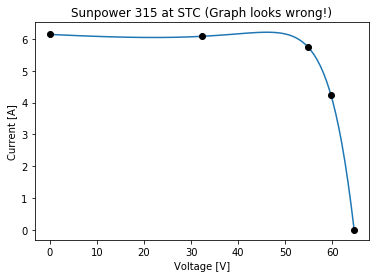

In [53]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)


iv_frame = sapm_to_ivframe(spr_315_5_points)
fit_voltages, fit_currents = ivframe_to_ivcurve(iv_frame)

import matplotlib.pyplot as plt
plt.plot(fit_voltages, fit_currents)
plt.plot(iv_frame['voltage'], iv_frame['current'], 'ko')
plt.title('Sunpower 315 at STC (Graph looks wrong!)')
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.plot()